In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

data = np.load('/Users/arinaruck/Desktop/cs/characters classification/train-1.npy')
data = np.vstack((data, np.load('/Users/arinaruck/Desktop/cs/characters classification/train-2.npy')))
data = np.vstack((data, np.load('/Users/arinaruck/Desktop/cs/characters classification/train-3.npy')))
data = np.vstack((data, np.load('/Users/arinaruck/Desktop/cs/characters classification/train-4.npy'))) 

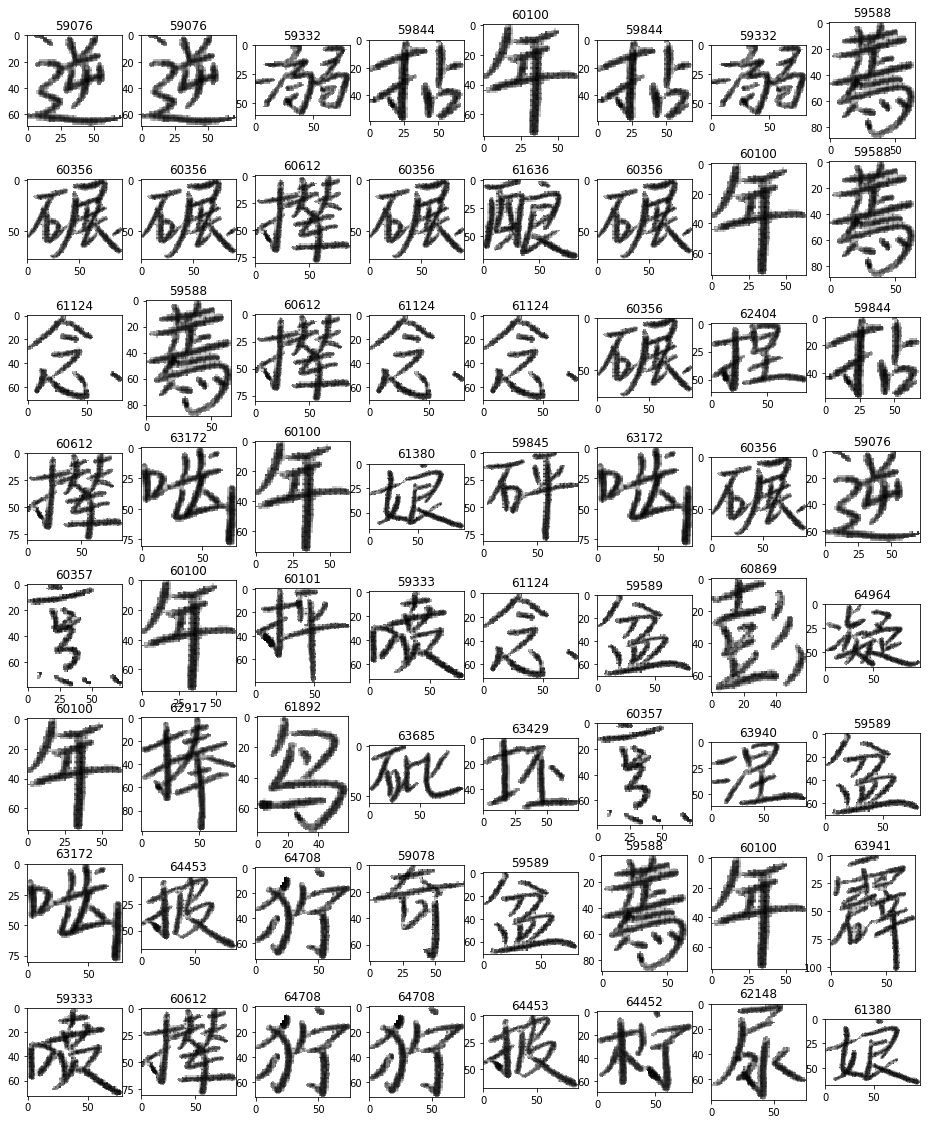

In [2]:
width, height = 8, 8

fig = plt.figure(figsize=(16, 20))
for n, (image, tag) in enumerate(data, 1):
    if n > width * height:
        break
    plt.subplot(height, width, n)
    plt.title(tag)
    plt.imshow(image, cmap='gray')   
plt.show()   

In [3]:
import torch
from torch import utils
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
from torch.autograd import Variable
import sys
sys.path.append('../')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn import datasets

%matplotlib inline
        
def plot_graphs(log, epochs, title, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in log.keys()}
    epochs = {k:epochs for k in log.keys()}
    #print(epochs)
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in log.keys()])
        plt.title(title + ', errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title(title + ', accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show() 

In [4]:
data_s = data.shape[0]
test_s = data_s // 5
train_s = data_s - test_s
x_train, x_test, y_train, y_test = train_test_split(data[:, 0], data[:, 1], test_size=test_s)  
print(x_train[1].shape, y_train.shape, x_test.shape, y_test.shape)

(98, 112) (266390,) (66597,) (66597,)


In [5]:
y_train = y_train.astype(np.long)
y_test = y_test.astype(np.long)
lables = np.unique(np.concatenate([y_test, y_train]))
lables.sort()
uni_to_class = {}
class_to_uni = {}
for i in range(1000):
    uni_to_class[lables[i]] = i
    class_to_uni[i] = lables[i]
target_train = torch.zeros(train_s, dtype=torch.long)
target_test = torch.zeros(test_s, dtype=torch.long)
for i in range(train_s):
    target_train[i] = uni_to_class[y_train[i]]
for i in range(test_s):
    target_test[i] = uni_to_class[y_test[i]]    

In [6]:
#img = x_train[0]
new_size = 48

def resize(img):
    h, w  = img.shape
    diff = abs(h - w)
    vframe = np.ones((h, diff // 2)) * 255
    hframe = np.ones((diff // 2, w)) * 255
    if h > w:
        img = np.hstack((vframe, img))
        img = np.hstack((img, vframe))
    else:
        img = np.vstack((hframe, img))
        img = np.vstack((img, hframe))
    img = cv2.resize(img, (new_size, new_size))
    img = torch.from_numpy(img.astype(np.float32))
    return img    


def regularize(x):
    mean = torch.mean(x, 0)
    std = torch.std(x)
    x -= mean
    x /= std
    return mean, std
    
#img = resize(img)
#print(img)
#print(img.shape)
print(x_test[0], x_test[0].shape)

[[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 165 168 255]
 [255 255 255 ..., 145 150 197]
 [255 255 255 ..., 172 178 255]] (71, 63)


In [7]:
for i in range(train_s):
    x_train[i] = resize(x_train[i])
for i in range(test_s):
    x_test[i] = resize(x_test[i])

In [8]:
print(x_train[1].shape)
print(x_test[0].shape)

torch.Size([48, 48])
torch.Size([48, 48])


In [9]:
class CNN(torch.nn.Module):    
    def __init__(self):
        super(CNN, self).__init__()
        # batch_size x 1 x 48 x 48 
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        # batch_size x 16 x 48 x 48
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        #batch_size x 16 x 24 x 24
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(32, 48, kernel_size=3, stride=1, padding=1)
        # batch_size x 48 x 24 x 24
        #pool
        #batch_size x 48 x 12 x 12
        self.fc1 = torch.nn.Linear(48 * 12 * 12, 2000)
        self.fc2 = torch.nn.Linear(2000, 1000)
        
    def forward(self, x):
        x = x.view(-1, 1, 48, 48)
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = self.pool(x)
        x = self.pool(x)
        x = x.view(-1, 48 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)

In [10]:
class CNN4(torch.nn.Module):    
    def __init__(self):
        super(CNN4, self).__init__()
        # batch_size x 1 x 48 x 48 
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=3)
        # batch_size x 16 x 48 x 48
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        #batch_size x 16 x 24 x 24
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        #pool
        # batch_size x 32 x 12 x 12
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = torch.nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1)
        self.conv5 = torch.nn.Conv2d(96, 128, kernel_size=3, stride=1, padding=1)
        # batch_size x 128 x 12 x 12
        #pool
        #batch_size x 128 x 6 x 6
        self.fc1 = torch.nn.Linear(128 * 6 * 6, 2000)
        self.fc2 = torch.nn.Linear(2000, 1000)
        
    def forward(self, x):
        x = x.view(-1, 1, 48, 48)
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)

In [12]:
x_train = torch.stack(x_train.tolist())
x_test = torch.stack(x_test.tolist())

In [13]:
mean, std = regularize(x_train)
x_test -= mean
x_test /= std
print(x_train.size())

torch.Size([266390, 48, 48])


In [14]:
l1_lmbd = 0.15
l2_lmbd = 0.25
def li_loss(layer, i):
    return torch.norm(layer.weight.data, p=i) 

In [15]:
model4 = CNN4()
optimizer = optim.Adam(model4.parameters(), lr=0.0005)

In [16]:
batch_s = 64
def train(model, epoch):
    loss = 0
    idx = 0
    for i in range(train_s // batch_s):
        data, target = x_train[idx : idx + batch_s], target_train[idx : idx + batch_s]
        idx += batch_s    
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target) + l1_lmbd * li_loss(model.fc1, 1) \
        +  l1_lmbd * li_loss(model.fc2, 1) +  l2_lmbd * li_loss(model.fc1, 2) +  l2_lmbd * li_loss(model.fc2, 2)
        #loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if i % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx, len(x_train),
                100. * idx / len(x_train), loss.data.item()))

        
def test(model, log=None):
    with torch.no_grad():
        test_loss = 0
        test_correct = 0
        idx = 0
        for i in range(test_s // batch_s):
            data, target = x_test[idx : idx + batch_s], target_test[idx : idx + batch_s]
            idx += batch_s
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').data.item() 
            pred = output.data.max(1, keepdim=True)[1]
            test_correct += pred.eq(target.data.view_as(pred)).sum()
            test_loss /= train_s
            test_correct_percent = 100. * test_correct / test_s

        train_loss = 0
        train_correct = 0
        idx = 0
        for i in range(train_s // batch_s):
            data, target = x_train[idx : idx + batch_s], target_train[idx : idx + batch_s]
            data, target = data, target
            idx += batch_s
            output = model(data)
            train_loss += F.cross_entropy(output, target, reduction='sum').data.item()
            pred = output.data.max(1, keepdim=True)[1]
            train_correct += pred.eq(target.data.view_as(pred)).sum()
        train_loss /= train_s
        train_correct_percent = 100. * train_correct / train_s
    
    print('\nTest set:  Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, test_correct, test_s, test_correct_percent))
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, train_s, train_correct_percent))
    
    log['test'].append((test_loss, test_correct_percent))
    log['train'].append((train_loss, train_correct_percent))  

In [17]:
def weights_init(model): 
    if type(model) == nn.Linear:
        torch.nn.init.xavier_normal_(model.weight, gain=1.2)
        model.bias.data.fill_(0.01)

        
def train_n_test(model, title, epoc_num, train=train):
    model.apply(weights_init)
    err_log = {'test': [], 'train': []}
    epochs = range(1, epoc_num)
    for epoch in epochs:
        train(model, epoch)
        print("epochs: ", epoch)
        test(model, err_log)
    plot_graphs(err_log, epochs, title, 'loss')
    plot_graphs(err_log, epochs, title, 'accuracy')

Train Epoch: 1 [64/266390 (0%)]	Loss: 30795.656250
Train Epoch: 1 [12864/266390 (5%)]	Loss: 34430.691406
Train Epoch: 1 [25664/266390 (10%)]	Loss: 37838.949219
Train Epoch: 1 [38464/266390 (14%)]	Loss: 39653.917969
Train Epoch: 1 [51264/266390 (19%)]	Loss: 40827.652344
Train Epoch: 1 [64064/266390 (24%)]	Loss: 41815.917969
Train Epoch: 1 [76864/266390 (29%)]	Loss: 42508.160156
Train Epoch: 1 [89664/266390 (34%)]	Loss: 43220.023438
Train Epoch: 1 [102464/266390 (38%)]	Loss: 43894.656250
Train Epoch: 1 [115264/266390 (43%)]	Loss: 44446.921875
Train Epoch: 1 [128064/266390 (48%)]	Loss: 44983.273438
Train Epoch: 1 [140864/266390 (53%)]	Loss: 45537.464844
Train Epoch: 1 [153664/266390 (58%)]	Loss: 46093.937500
Train Epoch: 1 [166464/266390 (62%)]	Loss: 46722.265625
Train Epoch: 1 [179264/266390 (67%)]	Loss: 47276.117188
Train Epoch: 1 [192064/266390 (72%)]	Loss: 47846.867188
Train Epoch: 1 [204864/266390 (77%)]	Loss: 48385.796875
Train Epoch: 1 [217664/266390 (82%)]	Loss: 48971.398438
Train

Train Epoch: 7 [102464/266390 (38%)]	Loss: 102918.578125
Train Epoch: 7 [115264/266390 (43%)]	Loss: 103260.546875
Train Epoch: 7 [128064/266390 (48%)]	Loss: 103618.328125
Train Epoch: 7 [140864/266390 (53%)]	Loss: 103925.726562
Train Epoch: 7 [153664/266390 (58%)]	Loss: 104237.265625
Train Epoch: 7 [166464/266390 (62%)]	Loss: 104598.273438
Train Epoch: 7 [179264/266390 (67%)]	Loss: 104904.609375
Train Epoch: 7 [192064/266390 (72%)]	Loss: 105258.757812
Train Epoch: 7 [204864/266390 (77%)]	Loss: 105575.125000
Train Epoch: 7 [217664/266390 (82%)]	Loss: 105981.507812
Train Epoch: 7 [230464/266390 (87%)]	Loss: 106366.000000
Train Epoch: 7 [243264/266390 (91%)]	Loss: 106717.914062
Train Epoch: 7 [256064/266390 (96%)]	Loss: 107087.968750
epochs:  7

Test set:  Average loss: 0.0000, Accuracy: 64770/66597 (97%)
Train set: Average loss: 0.0162, Accuracy: 265099/266390 (99%)

Train Epoch: 8 [64/266390 (0%)]	Loss: 107337.453125
Train Epoch: 8 [12864/266390 (5%)]	Loss: 107708.382812
Train Epoch: 8 

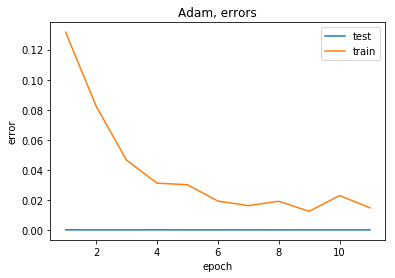

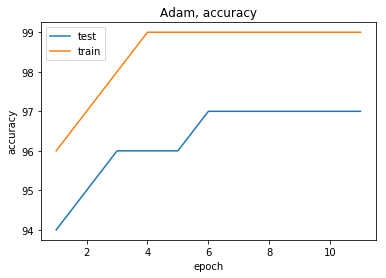

In [18]:
model4 = CNN4()
optimizer = optim.Adam(model4.parameters(), lr=0.0005)
train_n_test(model4, "Adam", 12)

In [26]:
test_data = np.load('/Users/arinaruck/Desktop/cs/characters classification/test.npy')
test_data_s = len(test_data)
print(test_data[0].shape)
for i in range(test_data_s):
    test_data[i] = resize(test_data[i])
test_data = torch.stack(test_data.tolist())
test_data -= mean
test_data /=std
print(test_data.shape)

(96, 90)
torch.Size([83247, 48, 48])


In [31]:
import csv

def out(model, num):
    with open('/Users/arinaruck/Desktop/cs/characters classification/out' + num + '.csv', 'w') as out_file:
        fieldnames = ['Id', 'Category']
        wr = csv.DictWriter(out_file, fieldnames=fieldnames)
        wr.writeheader()
        with torch.no_grad():
            idx = 0
            for i in range(test_data_s // batch_s):
                data_batch = test_data[idx : idx + batch_s]
                data_batch = Variable(data_batch)
                data_batch = data_batch
                output = model(data_batch)
                pred = output.data.max(1, keepdim=True)[1]
                for i in range(len(pred)):
                    wr.writerow({'Id' : i + idx + 1 , 'Category' : class_to_uni[pred[i].item()]})
                idx += batch_s
            data_batch = test_data[idx : ]
            data_batch = Variable(data_batch)
            data_batch = data_batch
            output = model(data_batch)
            pred = output.data.max(1, keepdim=True)[1]
            for i in range(len(pred)):
                wr.writerow({'Id' : i + idx + 1 , 'Category' : class_to_uni[pred[i].item()]})          

In [30]:
out(model4, '4')

In [35]:
with open('/Users/arinaruck/Desktop/cs/characters classification/out4.csv', newline='') as csvfile:
    output = csv.reader(csvfile, delimiter=' ')
    num = 0
    for row in output:
        print('  '.join(row))
        num += 1
        if num > 10:
            break

Id,Category
1,63955
2,64432
3,64709
4,64177
5,61881
6,61911
7,63185
8,63934
9,58837
10,61649
